In [33]:
# On importe la librairie bigml
from bigml.api import BigML

In [34]:
# On se connecte à bigml
api = BigML(project='project/5d94a32e42129f2e16000232')

In [35]:
# On crée une source à partir du csv
source_train = api.create_source('storage/source_dataset_train_full.csv')
source_test = api.create_source('storage/source_dataset_test.csv')
api.ok(source_test)

True

In [ ]:
# On crée un dataset à partir de la source puis on split (DATASET de TRAIN)
dataset_train_full = api.create_dataset(source_train, {"name": "Dataset Train Full"})
dataset_train_train = api.create_dataset(dataset_train_full, {"name": "Dataset Train Train", "sample_rate": 0.8, "seed": "my seed"})
dataset_train_test = api.create_dataset(dataset_train_full, {"name": "Dataset Train Test", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})

# On crée un dataset à partir de la source (DATASET de TEST)
dataset_test = api.create_dataset(source_test, {"name": "Dataset Test"})
api.ok(dataset_test)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.83611, 0.84263, 0.84951, 0.85303, 0.85353, 0.85327, 0.85478, 0.8557, 0.85633, 0.85531]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.83753, 0.84543, 0.84529, 0.83902, 0.84311, 0.83984, 0.83517, 0.84051, 0.84467, 0.84591]


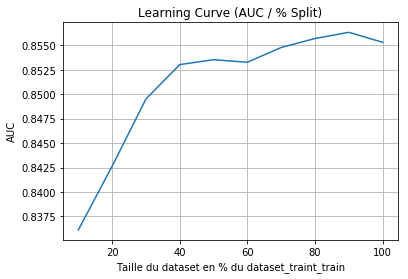

In [47]:
# Learning Curves
graph_x = []
graph_y = []
graph_x_deepnet = []
graph_y_deepnet = []
for i in range(1,11): # On boucle sur l'axe des abscisses / Taille du dataset de train / % de ligne du dataset de train_train
    # On crée le nouveau dataset de train à partir du dataset de train initial
    dataset_train_train_split = api.create_dataset(dataset_train_train, {"name": "Dataset Train Train " + str(i/10), "sample_rate": i/10, "seed": "my seed"})
    api.ok(dataset_train_train)    
    # On crée le modèle (ensemble) à partir du dataset split
    ensemble = api.create_ensemble(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
    api.ok(ensemble)
    # On évalue le nouveau modèle (ensemble)
    evaluation = api.create_evaluation(ensemble, dataset_train_test)
    api.ok(evaluation)
    # On crée le modèle (deepnet) à partir du dataset split
    deepnet = api.create_deepnet(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
    api.ok(deepnet)
    # On évalue le nouveau modèle (deepnet)
    evaluation_deepnet = api.create_evaluation(deepnet, dataset_train_test)
    api.ok(evaluation_deepnet)
    
    # On stocke dans une liste la valeur de l'axe des abscisses (graph_x) et la valeur de l'AUC (graph_y) à partir de la donnée BigML
    graph_x.append(i*10)
    graph_y.append(evaluation['object']['result']['model']['average_area_under_roc_curve'])
    graph_x_deepnet.append(i*10)
    graph_y_deepnet.append(evaluation_deepnet['object']['result']['model']['average_area_under_roc_curve'])
    i += 1

print(graph_x)
print(graph_y)
print(graph_x_deepnet)
print(graph_y_deepnet)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(graph_x, graph_y)
ax.set(xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='Learning Curve (AUC / % Split)')
ax.grid()
plt.show()

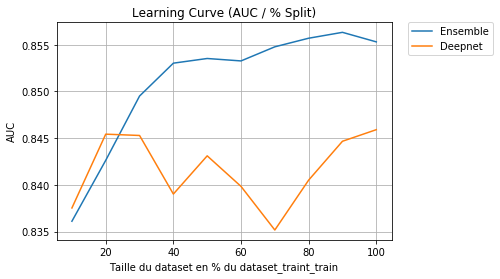

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(graph_x, graph_y, label='Ensemble')
ax.plot(graph_x_deepnet, graph_y_deepnet, label='Deepnet')
ax.set(xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

In [ ]:
# On lance un ensemble
ensemble = api.create_ensemble(dataset_train_train, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble"})
ensemble_full = api.create_ensemble(dataset_train_full, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble Full"})

In [ ]:
# On lance un batch sur le dataset TEST
batch_prediction = api.create_batch_prediction(ensemble_full, dataset_test, {"name": "Batch Prediction", "output_fields": ["Id"], "probabilities": True})
# On vérifie le bon fonctionnement du batch
api.ok(batch_prediction)

In [ ]:
# On lance un batch sur le dataset Train de validation
batch_prediction_all_fields = api.create_batch_prediction(ensemble, dataset_train_test, {"name": "Batch Prediction All Fields", "prediction_name" : "SeriousDlqin2yrs_Predic", "all_fields": True, "probabilities": True,})
# On vérifie le bon fonctionnement du batch
api.ok(batch_prediction_all_fields)

In [ ]:
# On récupère le ROC AUC via une évaluation
evaluation = api.create_evaluation(ensemble, dataset_train_test)
api.ok(evaluation)

In [ ]:
# On récupère le ROC AUC via une évaluation
evaluation_full = api.create_evaluation(ensemble_full, dataset_train_test)
api.ok(evaluation_full)

In [ ]:
# On affiche l'AUC depuis l'évaluation
#api.pprint(evaluation['object']['result'])
AUC = evaluation['object']['result']['model']['average_area_under_roc_curve']
print(f" AUC = {AUC}")

AUC = evaluation_full['object']['result']['model']['average_area_under_roc_curve']
print(f" AUC = {AUC}")

In [ ]:
# On télécharge les csv du batch et des datasets ainsi que le json de l'évaluation
api.download_batch_prediction(batch_prediction, filename='storage/batch_prediction.csv')
api.download_batch_prediction(batch_prediction_all_fields, filename='storage/batch_prediction_all_fields.csv')
api.download_dataset(dataset_train_full, filename='storage/dataset_train_full.csv')
api.download_dataset(dataset_train_train, filename='storage/dataset_train_train.csv')
api.download_dataset(dataset_train_test, filename='storage/dataset_train_test.csv')
api.download_dataset(dataset_test, filename='storage/dataset_test.csv')
api.export(evaluation, filename='storage/my_evaluation.json')